In [1]:
# standart libs
import sys
import random
import copy
import cProfile


# 3rd party libs
import pandas as pd
import numpy as np
import gempy as gp
import matplotlib.pyplot as plt
import matplotlib


# local
import functions.realization_setup as real_setup
import functions.realization_run as real_run
import functions.post_processing as post_pro
import functions.uq_runs as uq_runs

# executable
print(sys.executable)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


/home/namur/coding/notebooks/env/bin/python3


In [2]:
# instantiate the geo_model
geo_model = gp.create_model("GeoModel")

# defautl data
geo_model = gp.init_data(
    geo_model,
    extent=[0, 1, 0, 1, 0, 1],
    resolution=[1, 1, 1]
)

# compile theno function
gp.set_interpolation_data(
    geo_model,
    compile_theano=True,
    theano_optimizer='fast_run',
)



Active grids: ['regular']
Setting kriging parameters to their default values.
Compiling theano function...
Level of Optimization:  fast_run
Device:  cpu
Precision:  float64
Number of faults:  0
Compilation Done!
Kriging values: 
                     values
range              1.73205
$C_o$            0.0714286
drift equations        [3]


In [3]:
# meta
geo_model_extent_1 = [0,1000,0,1000,0,1000]
section_1 = {
    'p1': [0, 500],
    'p2': [1000, 500],
    'resolution': [200, 200]
}

# sereis
series_df_1 = pd.DataFrame(columns=['name', 'isfault', 'order_series'])
series_df_1.loc[0] = { 'order_series': 0, 'name': 'Basement_Series', 'isfault': False }
series_df_1.loc[1] = { 'order_series': 1, 'name': 'Strat_Series', 'isfault': False }

# surfaces
surfaces_df_1 = pd.DataFrame(columns=['name', 'serie', 'order_surface'])
surfaces_df_1.loc[0] = { 'name': 'basement', 'serie': 'Basement_Series', 'order_surface': 0 }
surfaces_df_1.loc[2] = { 'name': 'rock1', 'serie': 'Strat_Series', 'order_surface': 1 }
surfaces_df_1.loc[1] = { 'name': 'rock2', 'serie': 'Strat_Series', 'order_surface': 2 }

# geoData
surface_points_input_data_1 = pd.read_csv('./data/model2_surface_points.csv')
orientaions_input_data_1 = pd.read_csv('./data/model2_orientations.csv')

# Format geological_input_data
surface_points_original_df_1 = surface_points_input_data_1[['X', 'Y', 'Z', 'formation']]

# rename colums
surface_points_original_df_1.columns = ['X', 'Y', 'Z', 'surface']

# add distribution type and parameter
surface_points_original_df_1['param1'] = 10

# Orientaions
orientations_original_df_1 = orientaions_input_data_1[['X', 'Y', 'Z', 'dip', 'azimuth', 'polarity', 'formation']]

In [4]:
# %%timeit
# setup model 1
real_setup.setup_realization(
        geo_model=geo_model,
        geo_model_extent=geo_model_extent_1,
        section=section_1,
        series_df=series_df_1,
        surfaces_df=surfaces_df_1,
        surface_points_original_df=surface_points_original_df_1,
        orientations_original_df=orientations_original_df_1
)

if real_run.check_setup_single_realization(geo_model):
    solution = gp.compute_model(model=geo_model, sort_surfaces=False)



Active grids: ['regular']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
HOTFIX in update_surfaces()
Run realizations setup checks until stable workflow.


In [5]:
Bx = post_pro.compute_boolean_matrix_for_section_surface_top(geo_model)

extent = { 'z_min': 0, 'z_max': 1000 }
section_coordinates = post_pro.compute_setction_grid_coordinates(geo_model, extent)

tops_dict = post_pro.get_tops_coordinates(Bx, section_coordinates)

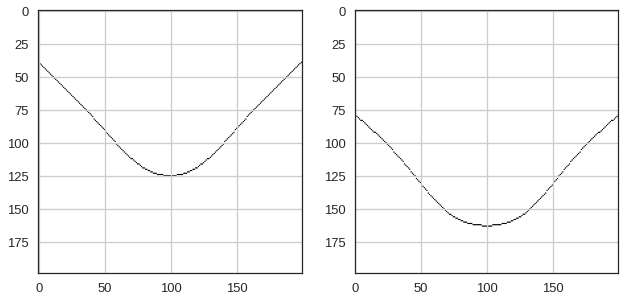

In [6]:
# plot for sanity check
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(Bx['0-1'])
ax1.grid()
ax2.imshow(Bx['0-2'])
ax2.grid()
plt.show()

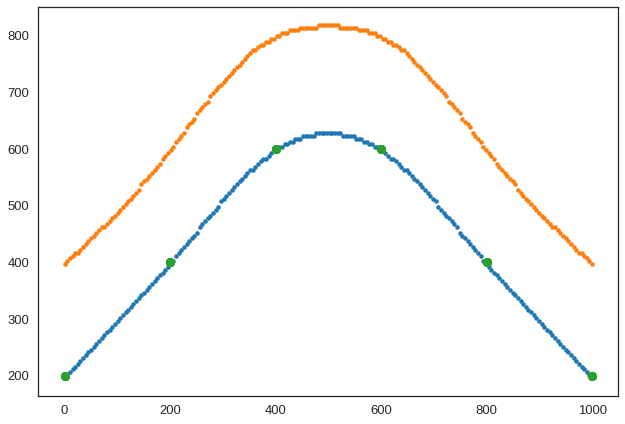

In [7]:
# plot original data
plt.plot(tops_dict['0-1']['xvals'], tops_dict['0-1']['zvals'], '.')
plt.plot(tops_dict['0-1']['xvals'], tops_dict['0-2']['zvals'], '.')
plt.plot(
    surface_points_original_df_1[surface_points_original_df_1.surface == 'rock1']['X'],
    surface_points_original_df_1[surface_points_original_df_1.surface == 'rock1']['Z'],
    'o'
)
plt.show()

In [8]:
# Pass origin data to mode
real_setup.setup_realization(
        geo_model=geo_model,
        geo_model_extent=geo_model_extent_1,
        section=section_1,
        series_df=series_df_1,
        surfaces_df=surfaces_df_1,
        surface_points_original_df=surface_points_original_df_1,
        orientations_original_df=orientations_original_df_1
)

# recompute
if real_run.check_setup_single_realization(geo_model):
    solution = gp.compute_model(model=geo_model, sort_surfaces=False)

# extract tops
Bx = post_pro.compute_boolean_matrix_for_section_surface_top(geo_model)

extent = { 'z_min': 0, 'z_max': 1000 }
section_coordinates = post_pro.compute_setction_grid_coordinates(geo_model, extent)

tops_dict = post_pro.get_tops_coordinates(Bx, section_coordinates)

Active grids: ['regular' 'sections']
Active grids: ['regular' 'sections']
HOTFIX in update_series()
Run realizations setup checks until stable workflow.


In [9]:
# get interpolated tops and extract one
x = tops_dict['0-1']['xvals']
y = tops_dict['0-1']['yvasl']
z = tops_dict['0-1']['zvals']

# add noise to the top
noise = np.random.normal(0,5,len(x))
xx = x + noise
noise = np.random.normal(0,5,len(y))
yy = y + noise
yy = np.array(y)
noise = np.random.normal(0,5,len(z))
zz = z + noise

# remove points that are out of bound
xx[xx < 0], xx[xx > 1000] = 0, 1000
yy[yy < 0], yy[yy > 1000] = 0, 1000
zz[zz < 0], zz[zz > 1000] = 0, 1000

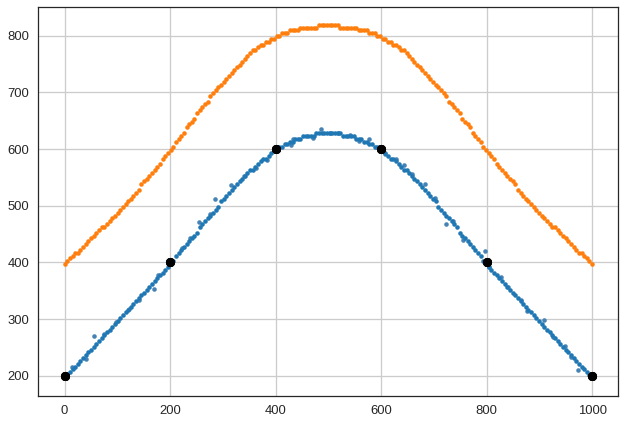

In [10]:
# plot
plt.plot(xx[::4],zz[::4], '.', color='steelblue')
plt.plot(tops_dict['0-1']['xvals'], tops_dict['0-1']['zvals'], '.')
plt.plot(tops_dict['0-1']['xvals'], tops_dict['0-2']['zvals'], '.')
plt.plot(
    geo_model.surface_points.df[geo_model.surface_points.df.surface == 'rock1']['X'],
    geo_model.surface_points.df[geo_model.surface_points.df.surface == 'rock1']['Z'],
    'o',
    color='black'
)
plt.grid()

# Effect of noise and dense points in model

In [11]:
# creat new df including new noise data
df0 = surface_points_original_df_1
df1 = pd.DataFrame(columns=df0.columns)
df1.X = xx[::4]
df1.Y = yy[::4]
df1.Z = zz[::4]
df1.surface = 'rock1'
df1.param1 = 10

# concate into new df
df2 = pd.concat([df0, df1], ignore_index=True)

# set new surface points
geo_model.set_surface_points(df2, update_surfaces=False)
geo_model.update_to_interpolator()

# recompute
if real_run.check_setup_single_realization(geo_model):
    solution = gp.compute_model(model=geo_model, sort_surfaces=False)

# extract tops
Bx = post_pro.compute_boolean_matrix_for_section_surface_top(geo_model)

extent = { 'z_min': 0, 'z_max': 1000 }
section_coordinates = post_pro.compute_setction_grid_coordinates(geo_model, extent)

tops_dict = post_pro.get_tops_coordinates(Bx, section_coordinates)


Run realizations setup checks until stable workflow.


# ELISA!!! Hier das geo-model in 3D. Um zu zeigen wie uberfitted wird.

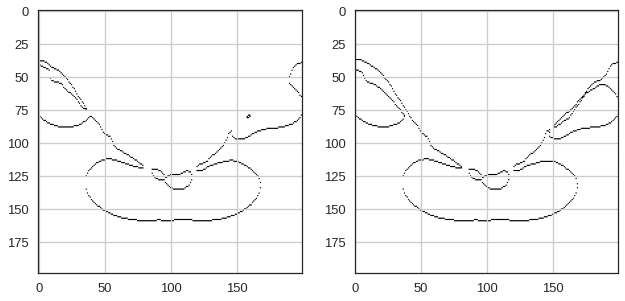

In [12]:
# plot for sanity check
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(Bx['0-1'])
ax1.grid()
ax2.imshow(Bx['0-2'])
ax2.grid()
plt.show()

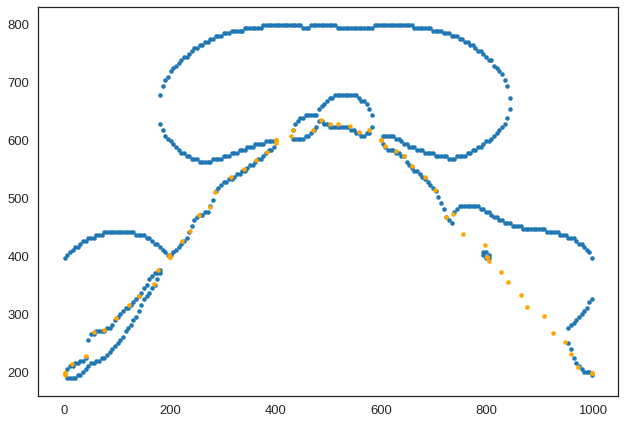

In [13]:
plt.plot(tops_dict['0-1']['xvals'], tops_dict['0-1']['zvals'], '.')
plt.plot(
    geo_model.surface_points.df[geo_model.surface_points.df.surface == 'rock1']['X'],
    geo_model.surface_points.df[geo_model.surface_points.df.surface == 'rock1']['Z'],
    '.',
    color='orange'
)

# Variogram to explain the range

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


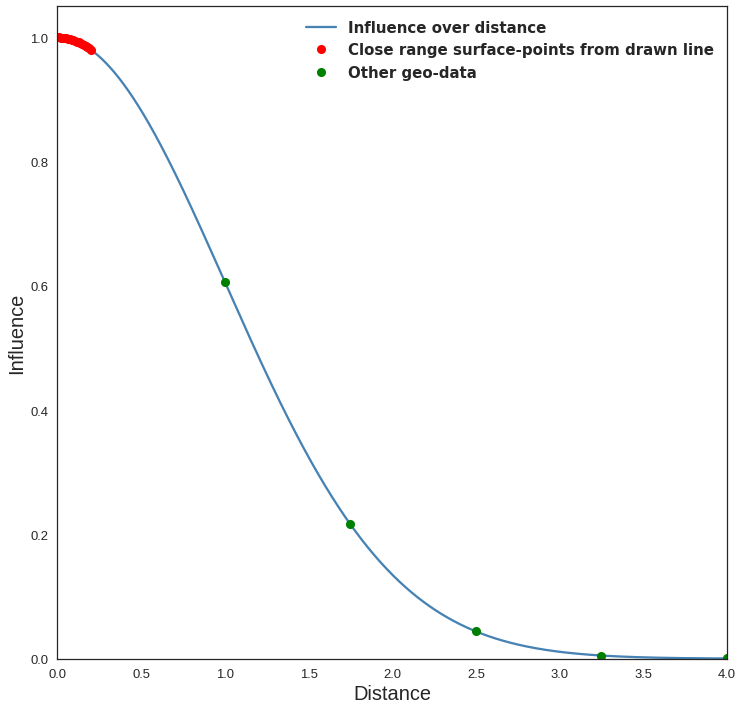

In [14]:
xvals = np.linspace(0,4,1000)
yvals = np.exp( -(xvals**2) / 2*1**2 )
_xx = np.linspace(0,0.2,20)
_yy = np.exp( -(_xx**2) / 2*1**2 )
xxx = np.linspace(1,4,5)
yyy = np.exp( -(xxx**2) / 2*1**2 )

fig, ax0 = plt.subplots(nrows=1, ncols=1, constrained_layout=False, figsize=(12, 12))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

ax0.plot(xvals, yvals, '-', c='steelblue', label='Influence over distance')
ax0.plot(_xx, _yy, 'o', c='red', label='Close range surface-points from drawn line')
ax0.plot(xxx, yyy, 'o', c='green', label='Other geo-data')

ax0.set_xlim([0,4])
ax0.set_ylabel('Influence', fontsize=20)
ax0.set_xlabel('Distance', fontsize=20)
ax0.set_ylim([0,1.05])
ax0.legend(loc='upper right', fontsize=15)
fig.savefig('../document/figures/discussion_range.png')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


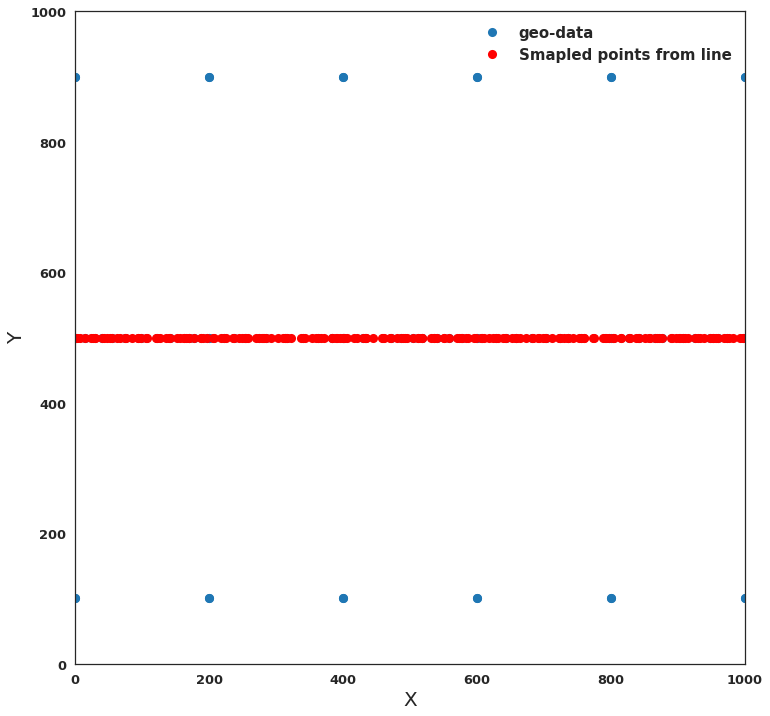

In [16]:
xvals = np.linspace(0,4,1000)
yvals = np.exp( -(xvals**2) / 2*1**2 )

fig, ax0 = plt.subplots(nrows=1, ncols=1, constrained_layout=False, figsize=(12, 12))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

ax0.plot(geo_model.surface_points.df.X, geo_model.surface_points.df.Y, 'o', label='geo-data')
ax0.plot(xx,np.ones(xx.shape) * 500, 'o', c='red', label='Smapled points from line')
ax0.set_xlim([0,1000])
ax0.set_ylabel('Y', fontsize=20)
ax0.set_xlabel('X', fontsize=20)
ax0.set_ylim([0,1000])
ax0.legend(loc='upper right', fontsize=15)
fig.savefig('../document/figures/discussion_point_distribution.png')